## 商業問題

#### 情境
假設你在一個結賬櫃檯，並試圖用卡支付 20 美元購買你帶來的夾克。<br>
在結帳過程，卡片顯示拒絕，突然從銀行發來一條短信到你的手機，上面寫著“如果你真的想花 20 美元買夾克，請按 1”。
#### 目標
雖然目前可能很麻煩（而且常常令人尷尬），但這種防欺詐系統實際上每年為消費者節省數百萬美元。<br> IEEE 計算智能協會 (IEEE-CIS) 的研究人員希望改善這一數字，同時改善客戶體驗。<br>



# Dataset

這裡我們需要預測一個在線交易是欺詐的概率，用二進制（binary）目標 isFraud 表示。

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

#### Transaction data 

* Transactionid: 交易ID
* TransactionDT: 來自給定參考日期時間的時間增量（不是實際時間戳）
* TransactionAMT: 以美元為單位的交易支付金額 
* ProductCD  [Categorical]:  產品代碼（每筆交易的產品）
* card1 - 6 [Categorical]: 支付卡相關信息，如卡類型、國家等 
* addr1, addr2 [Categorical]: 帳單地址資訊
* dist1,dist2: 一些距離信息，（不限於）帳單地址、郵寄地址、郵政編碼、IP 地址、電話區等之間的距離
* P_emaildomain [Categorical]: 購買者的電子郵件domain 
* R_emaildomain [Categorical]: 收件人的電子郵件domain 
* C1-C14:  計數，如發現有多少地址與支付卡關聯等，實際含義被屏蔽
* D1-D15: 時間增量，例如之前交易之間的天數等 
* M1-M9 [Categorical]: 匹配，如卡片上的名字和地址等 
* V1-V339: Vesta 設計了豐富的功能，包括排名、計數和其他實體關係。



#### Identity data

* Transactionid: 交易ID
* DeviceType [Categorical]: 用於交易的設備類型   
* DeviceInfo [Categorical]: 有關所用設備的更多信息 
* id 1 - 38 [Categorical+numeric]:  網絡連接信息、瀏覽器信息等（id 12-38為分類信息

Note: Actually we dont have access to exact information about columns. Mostly it is beacuse of security purposes as we are handling transaction data.


# 載入模型

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
plt.style.use('seaborn-whitegrid')
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]


In [ ]:
# load the data and merge the dataframes
df_train_transaction = pd.read_csv('./ieee-fraud-detection/train_transaction.csv')
df_train_identity = pd.read_csv('./ieee-fraud-detection/train_identity.csv')
df_train = df_train_transaction.merge(df_train_identity,on=['TransactionID'],how='left')
df_test_transaction = pd.read_csv('./ieee-fraud-detection/test_transaction.csv')
df_test_identity = pd.read_csv('./ieee-fraud-detection/test_identity.csv')

#some columns (id) are wrongly labeled in test_identity. We will correct it
id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
df_test_identity = df_test_identity.rename(columns=rename_cols)
df_test = df_test_transaction.merge(df_test_identity,on=['TransactionID'],how='left')
df_train.to_csv('./ieee-fraud-detection/train_combined.csv',index=False)
df_test.to_csv('./ieee-fraud-detection/test_combined.csv',index=False)

# EDA

In [ ]:
df_train = pd.read_csv('./ieee-fraud-detection/train_combined.csv')
df_test = pd.read_csv('./ieee-fraud-detection/test_combined.csv')
print('df_train_shape:',df_train.shape)
print('df_test_shape:',df_test.shape)


df_train_shape: (590540, 434)
df_test_shape: (506691, 433)


In [ ]:
df_train.describe

<bound method NDFrame.describe of         TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400          68.500         W   
1             2987001        0          86401          29.000         W   
2             2987002        0          86469          59.000         W   
3             2987003        0          86499          50.000         W   
4             2987004        0          86506          50.000         H   
5             2987005        0          86510          49.000         W   
6             2987006        0          86522         159.000         W   
7             2987007        0          86529         422.500         W   
8             2987008        0          86535          15.000         H   
9             2987009        0          86536         117.000         W   
10            2987010        0          86549          75.887         C   
11            2987011        0          86555          16.495     

In [ ]:
df_train.describe(include='all')  # data description # P(Y=1) ~ 3.5

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540,590540.000000,581607.000000,588975.000000,588963,586281.000000,...,140282,77586.000000,73289,77805,140985,140985,140985,140985,140810,118666
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,...,130,NaN,260,4,2,2,2,2,2,1786
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,NaN,NaN,NaN,NaN,439670,NaN,NaN,NaN,384767,NaN,...,22000,NaN,16874,60011,77814,134066,110452,73922,85165,47722
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,NaN,9898.734658,362.555488,153.194925,NaN,199.278897,...,NaN,26.508597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.704744e+05,0.183755,4.617224e+06,239.162522,NaN,4901.170153,157.793246,11.336444,NaN,41.244453,...,NaN,3.737502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.987000e+06,0.000000,8.640000e+04,0.251000,NaN,1000.000000,100.000000,100.000000,NaN,100.000000,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,NaN,6019.000000,214.000000,150.000000,NaN,166.000000,...,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,NaN,9678.000000,361.000000,150.000000,NaN,226.000000,...,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,NaN,14184.000000,512.000000,150.000000,NaN,226.000000,...,NaN,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def top_missing_cols(df, n=13, thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """

    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col', 'missing_percent']
    dff = dff.sort_values(by=['missing_percent'],
                          ascending=False).reset_index(drop=True)
    print(
        f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(
        f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    n = dff[dff["missing_percent"] > thresh].shape[0]
    if n:
        return dff.head(n)
    else:
        return dff

In [ ]:
top_missing_cols(df_train,thresh=90)

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


In [ ]:
top_missing_cols(df_test,thresh=90)

There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.064519
1,id_25,99.005508
2,id_26,99.003929
3,id_21,99.001561
4,id_08,99.001561
5,id_07,99.001561
6,id_27,99.000969
7,id_23,99.000969
8,id_22,99.000969
9,dist2,92.809030


## 1.Is_Fraud

In [ ]:
df_train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

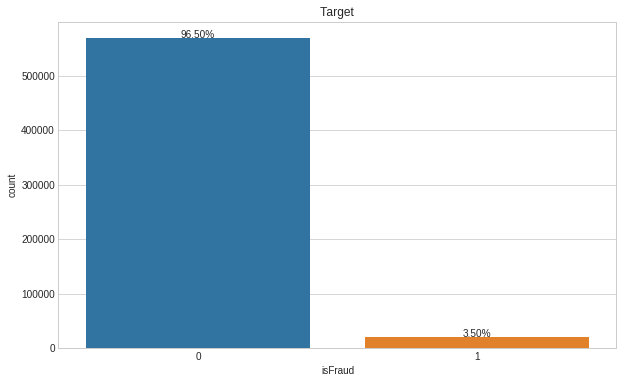

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.countplot(df_train['isFraud'])
axes.title.set_text('Target')
total = float(df_train['isFraud'].shape[0])
for p in axes.patches:
    height = p.get_height()
    axes.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.2f}%'.format(height*100/total),
              ha="center")
plt.show()


正如預期的那樣，我們的數據是高度不平衡的。大約 96.5% 的交易不是欺詐。只有約 3.5% 是欺詐交易

## 2.TransactionDate
在這裡，我們檢查訓練中獲得的數據，並且檢查測試是否連續。<br>
這對於訓練-測試分割很重要，意味著訓練數據應該來自更早的時期，而測試數據應該來自更晚的時期。

In [ ]:
print(df_train['TransactionDT'].isnull().sum())
df_test['TransactionDT'].isnull().sum()


0


0

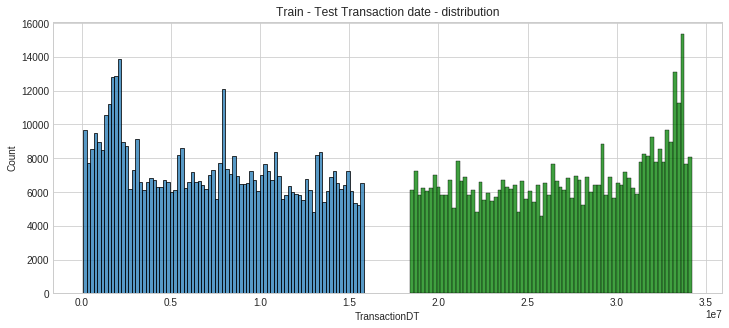

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
sns.histplot(df_train['TransactionDT'])
sns.histplot(df_test['TransactionDT'], color='g')
axes.title.set_text('Train - Test Transaction date - distribution')
plt.show()

1. 中間略有差距，訓練集來自較早的時間段，測試集來自較晚的時間段，這將影響待會的資料切割。
2. 某些天的交易次數超過 10000

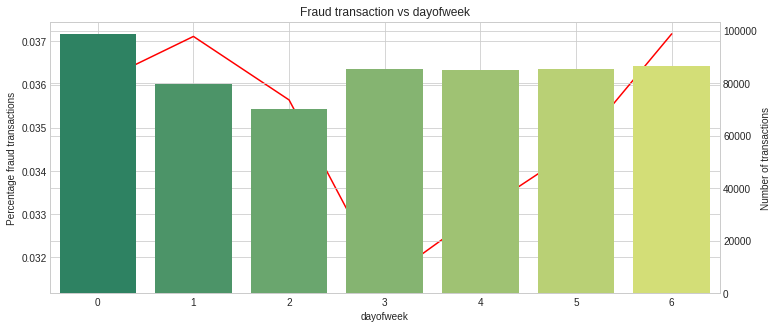

In [ ]:
df_train['dayofweek'] = (df_train['TransactionDT']//(60*60*24)-1) % 7
tmp = df_train[['isFraud', 'dayofweek']].groupby(by=['dayofweek']).mean().reset_index() \
    .rename(columns={'isFraud': 'Percentage fraud transactions'})

tmp_count = df_train[['TransactionID', 'dayofweek']].groupby(by=['dayofweek']).count().reset_index() \
    .rename(columns={'TransactionID': 'Number of transactions'})
tmp = tmp.merge(tmp_count, on=['dayofweek'])


fig, axes = plt.subplots(figsize=(12, 5))
axes = sns.lineplot(x=tmp['dayofweek'],
                    y=tmp['Percentage fraud transactions'], color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['dayofweek'],
                    y=tmp['Number of transactions'], palette='summer')
axes.set_title('Fraud transaction vs dayofweek')
plt.show()


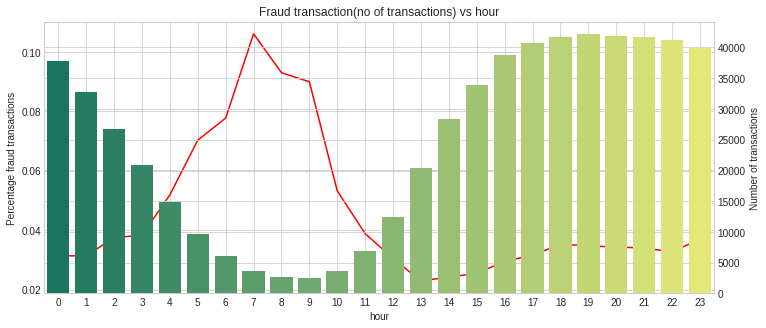

In [ ]:
df_train['hour'] = (df_train['TransactionDT']//(60*60)) % 24
tmp = df_train[['isFraud', 'hour']].groupby(by=['hour']).mean().reset_index() \
    .rename(columns={'isFraud': 'Percentage fraud transactions'})

tmp_count = df_train[['TransactionID', 'hour']].groupby(by=['hour']).count().reset_index() \
    .rename(columns={'TransactionID': 'Number of transactions'})
tmp = tmp.merge(tmp_count, on=['hour'])


fig, axes = plt.subplots(figsize=(12, 5))
axes = sns.lineplot(
    x=tmp['hour'], y=tmp['Percentage fraud transactions'], color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(
    x=tmp['hour'], y=tmp['Number of transactions'], palette='summer')
axes.set_title('Fraud transaction(no of transactions) vs hour')
plt.show()


我們可以看到，第 3 天的欺詐交易非常少，一天中在第 7 個小時，欺詐交易的百分比與其他時間相比較高

## 3.TransactionAmt
讓我們看看每小時交易的平均金額及其欺詐率

In [ ]:
print(df_train['TransactionAmt'].isnull().sum())
df_test['TransactionAmt'].isnull().sum()


0


0

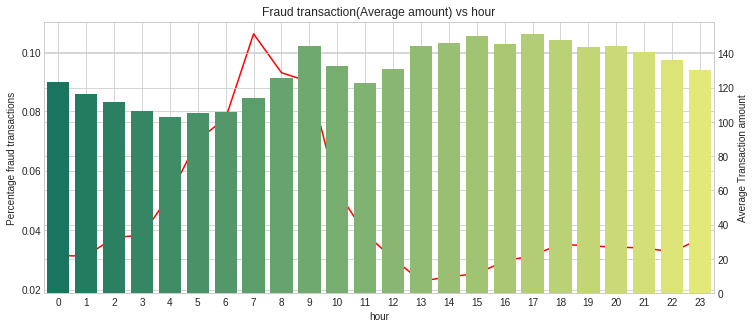

In [ ]:
df_train['hour'] = (df_train['TransactionDT']//(60*60)) % 24
tmp = df_train[['isFraud', 'hour']].groupby(by=['hour']).mean().reset_index() \
    .rename(columns={'isFraud': 'Percentage fraud transactions'})

tmp_amount = df_train[['TransactionAmt', 'hour']].groupby(by=['hour']).mean().reset_index() \
    .rename(columns={'TransactionAmt': 'Average Transaction amount'})
tmp = tmp.merge(tmp_amount, on=['hour'])


fig, axes = plt.subplots(figsize=(12, 5))
axes = sns.lineplot(
    x=tmp['hour'], y=tmp['Percentage fraud transactions'], color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(
    x=tmp['hour'], y=tmp['Average Transaction amount'], palette='summer')
axes.set_title('Fraud transaction(Average amount) vs hour')
plt.show()


### outlier 

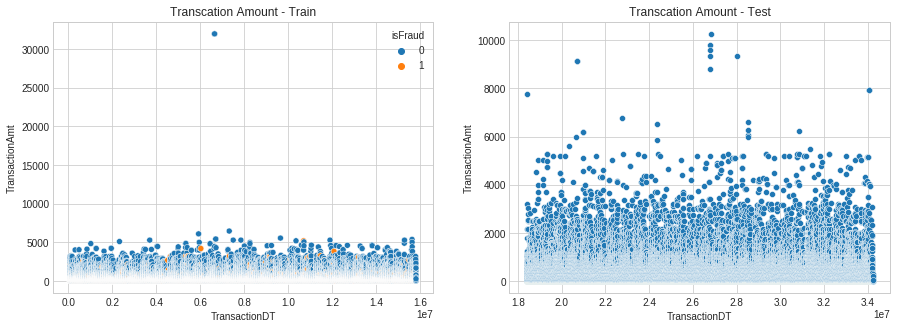

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(y=df_train['TransactionAmt'],
                x=df_train['TransactionDT'], hue=df_train['isFraud'], ax=axes[0])
axes[0].title.set_text('Transcation Amount - Train')

sns.scatterplot(y=df_test['TransactionAmt'],
                x=df_test['TransactionDT'], ax=axes[1])
axes[1].title.set_text('Transcation Amount - Test')

plt.show()


我們可以看到訓練數據中有一個點的數量 > 30000。
最好去除異常值，因為它會影響我們的模型（尤其是基於距離的算法，如邏輯回歸、knn 等）的預測。

In [ ]:
# df_train = df_train[df_train['TransactionAmt'] < 30000]
# df_train.shape

(590538, 434)

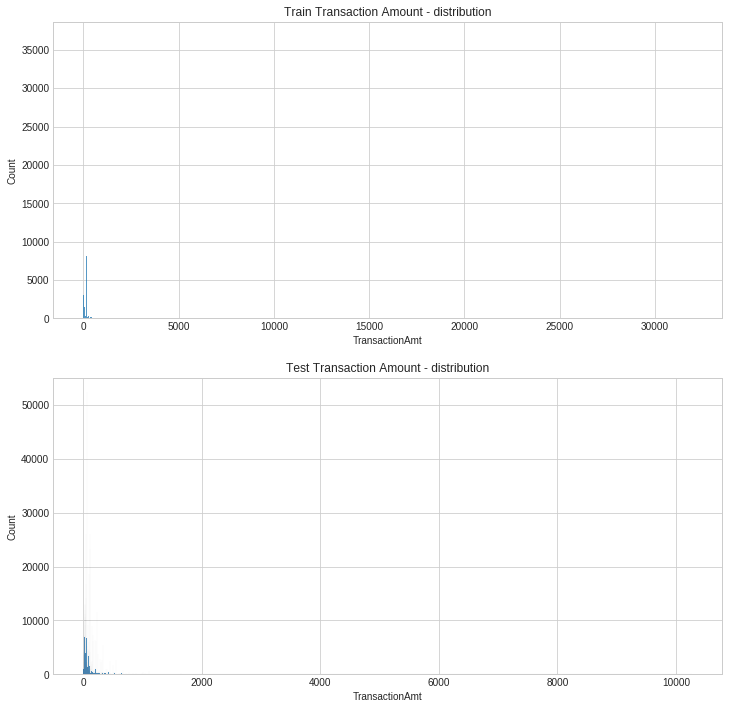

In train data Minimum transaction amount is 0.251 and maximum amount  is 31937.391
In test data Minimum transaction amount is 0.018000000000000002 and maximum amount  is 10270.0


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
sns.histplot(df_train['TransactionAmt'], ax=axes[0])
sns.histplot(df_test['TransactionAmt'], ax=axes[1])
axes[0].title.set_text('Train Transaction Amount - distribution')
axes[1].title.set_text('Test Transaction Amount - distribution')
plt.show()

print(
    f'In train data Minimum transaction amount is {df_train["TransactionAmt"].min()} and maximum amount  is {df_train["TransactionAmt"].max()}')
print(
    f'In test data Minimum transaction amount is {df_test["TransactionAmt"].min()} and maximum amount  is {df_test["TransactionAmt"].max()}')


我們要做log 轉換 
-否則少數非常大的金額會扭曲分佈，因為大多數交易的金額較小。

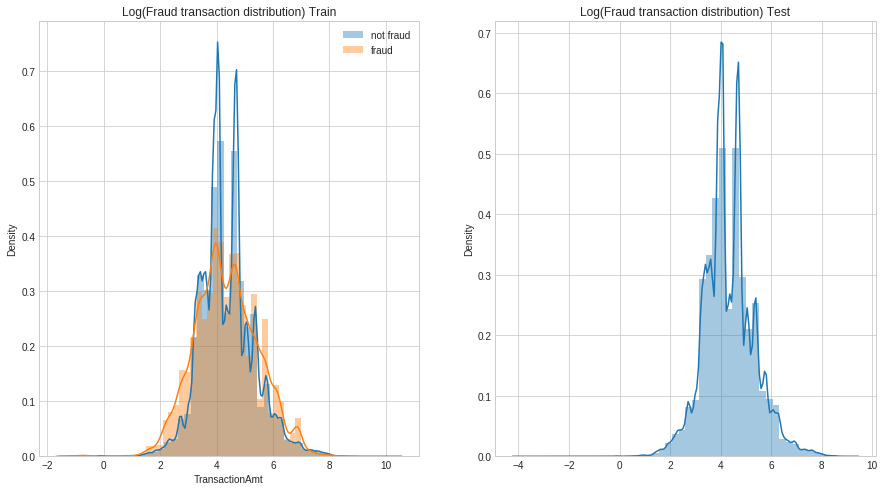

In [ ]:
test_amt = np.log(df_test[['TransactionAmt']])

dff_fraud = df_train[df_train['isFraud'] == 1]
dff_notfraud = df_train[df_train['isFraud'] == 0]

dff_fraud['TransactionAmt'] = np.log(dff_fraud['TransactionAmt'])
dff_notfraud['TransactionAmt'] = np.log(dff_notfraud['TransactionAmt'])


fig, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.distplot(dff_notfraud['TransactionAmt'], ax=axes[0], label='not fraud')
sns.distplot(dff_fraud['TransactionAmt'], ax=axes[0], label='fraud')
axes[0].title.set_text('Log(Fraud transaction distribution) Train')
axes[0].legend()

sns.distplot(test_amt, ax=axes[1])
axes[1].title.set_text('Log(Fraud transaction distribution) Test')
plt.show()


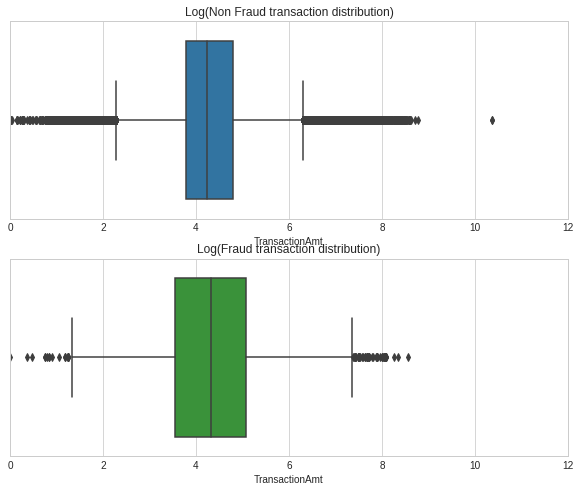

Mean transaction amt for fraud is 4.3506 ie, 77.5264 dollars
Mean transaction amt for non-fraud is 4.3643 ie, 78.5978 dollars
Median transaction amt for fraud is 4.3175  ie, 75.0000 dollars
Median transaction amt for non-fraud is 4.2268  ie, 68.5000 dollars


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))
sns.boxplot(dff_notfraud['TransactionAmt'],ax=axes[0])
axes[0].title.set_text('Log(Non Fraud transaction distribution)')
axes[0].set(xlim=(0, 12))
sns.boxplot(dff_fraud['TransactionAmt'],ax=axes[1],color=colors[2])
axes[1].title.set_text('Log(Fraud transaction distribution)')
axes[1].set(xlim=(0, 12))
plt.show()

print('Mean transaction amt for fraud is {:.4f} ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].mean(),np.exp(dff_fraud['TransactionAmt'].mean())))
print('Mean transaction amt for non-fraud is {:.4f} ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].mean(),np.exp(dff_notfraud['TransactionAmt'].mean())))

print('Median transaction amt for fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].median(),np.exp(dff_fraud['TransactionAmt'].median())))
print('Median transaction amt for non-fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].median(),np.exp(dff_notfraud['TransactionAmt'].median())))

1. 欺詐交易的中位數略高。
2. 同樣在欺詐交易中，我們有一個更好的正態分佈，它在鐘形曲線上很寬。它表明在特定時間段存在更多欺詐交易。
3. 'LogTransactionAmt' 大於 5.5（244 美元）且小於 3.3（27 美元）的交易似乎具有更高的欺詐機率。

## 4.ProductCD(類別型)

In [ ]:
print(df_train['ProductCD'].isnull().sum())
df_test['ProductCD'].isnull().sum()


0


0

In [ ]:
df_train['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

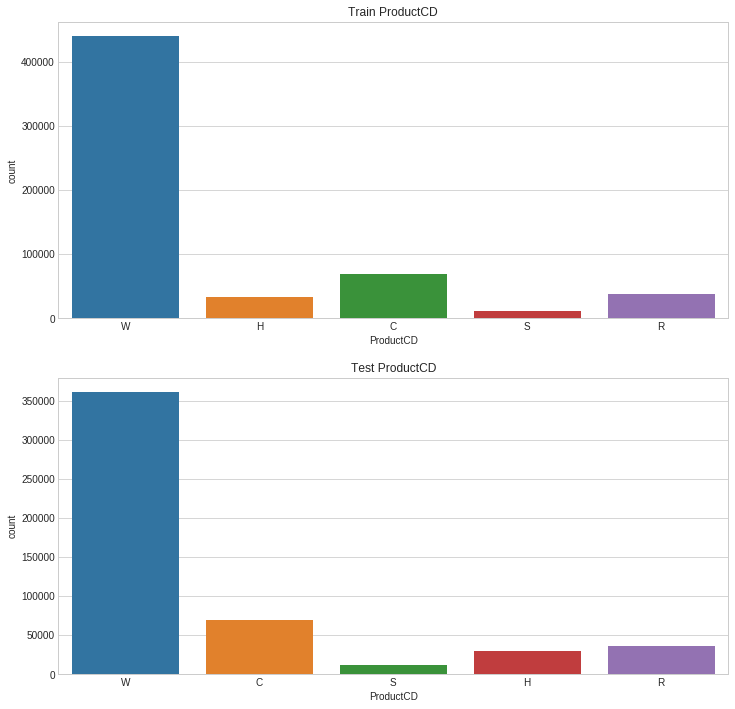

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
sns.countplot(df_train['ProductCD'], ax=axes[0])
sns.countplot(df_test['ProductCD'], ax=axes[1])
axes[0].title.set_text('Train ProductCD')
axes[1].title.set_text('Test ProductCD')    
plt.show()


In [ ]:
def hor_plot(feat, df=df_train, label_rotation=False, shape=(12, 8)):

    val_cnts = df[feat].value_counts()
    df1 = pd.DataFrame(
        {feat: val_cnts.index, 'Number of units': val_cnts.values})
    # Calculate the percentage of target=1 per category value.For that what we did is we took the mean value of TARGET
    percent = df[[feat, 'isFraud']].groupby([feat], as_index=False).mean()
    percent.sort_values(by='isFraud', ascending=False, inplace=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=shape)
    s = sns.barplot(ax=ax1, x=feat, y="Number of units", data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(), rotation=90)

    s = sns.barplot(ax=ax2, x=feat, y='isFraud',
                    order=percent[feat], data=percent)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(), rotation=90)

    plt.ylabel(
        'Percent of Fraud transactions [Target with value 1]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()


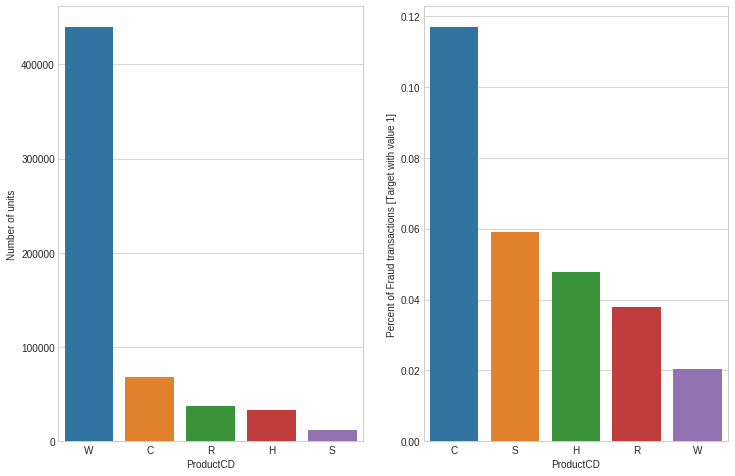

In [ ]:
hor_plot(df=df_train,feat='ProductCD')

1. 我們可以看到產品 W 在所有交易中出現最多。在欺詐交易中，產品 W 的數量也更多。但在所有產品 W 交易中，只有大約 2% 是欺詐。
2. 大約 11.5% 的 ProductC 是欺詐性交易
3. 此外，大約 6% 的 ProductS 交易是欺詐。

## 5.Card1 - Card6

In [ ]:
cards = [col for col in df_train.columns if 'card' in col]
print('train_data')
print(df_train[cards].isnull().sum())
print('test_data')
print(df_test[cards].isnull().sum())


train_data
card1       0
card2    8933
card3    1565
card4    1577
card5    4259
card6    1571
dtype: int64
test_data
card1       0
card2    8654
card3    3002
card4    3086
card5    4547
card6    3007
dtype: int64


card2-card6 都有些缺失職

In [ ]:
cards = [col for col in df_train.columns if 'card' in col]
df_train[cards].head()


,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [ ]:
print(df_train[cards].nunique())

card1    13553
card2      500
card3      114
card4        4
card5      119
card6        4
dtype: int64


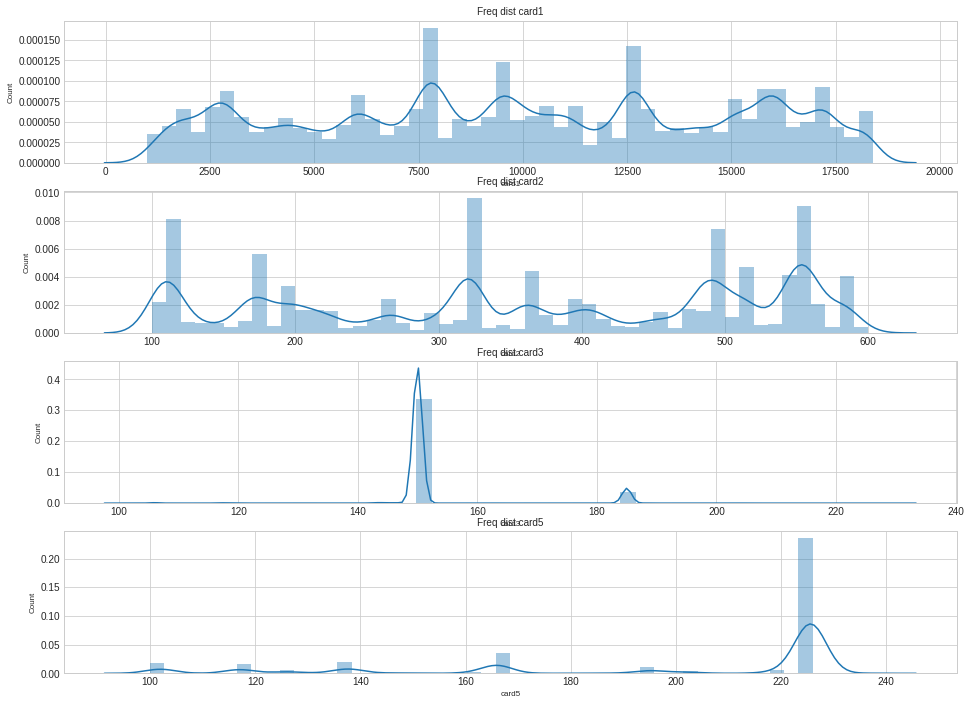

In [ ]:
col_names = ['card1','card2','card3','card5']
fig, ax = plt.subplots(len(col_names), figsize=(16, 12))
for i, col_val in enumerate(col_names):
    sns.distplot(df_train[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)
    

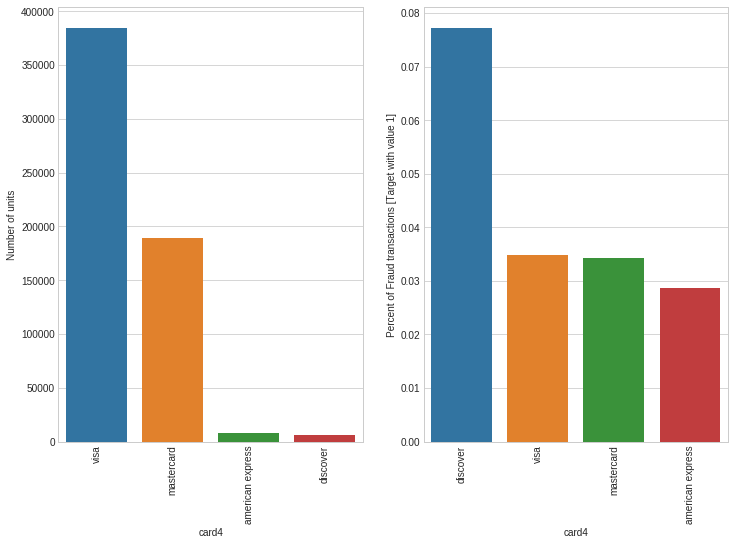

In [ ]:
hor_plot('card4',label_rotation=True)

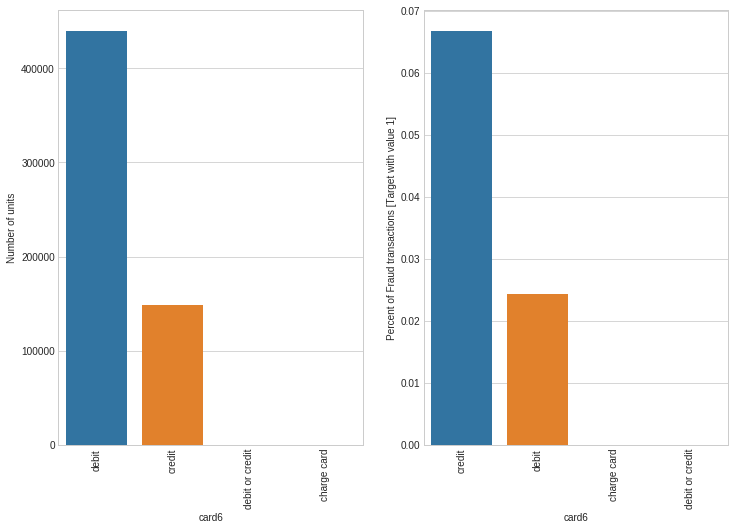

In [ ]:
hor_plot('card6',label_rotation=True)

In [ ]:
cards = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'isFraud']
df_train[cards].corr()

,card1,card2,card3,card5,isFraud
card1,1.000000,0.004960,0.002965,-0.093633,-0.013640
card2,0.004960,1.000000,0.023816,0.030486,0.003388
card3,0.002965,0.023816,1.000000,-0.158383,0.154151
card5,-0.093633,0.030486,-0.158383,1.000000,-0.033580
isFraud,-0.013640,0.003388,0.154151,-0.033580,1.000000


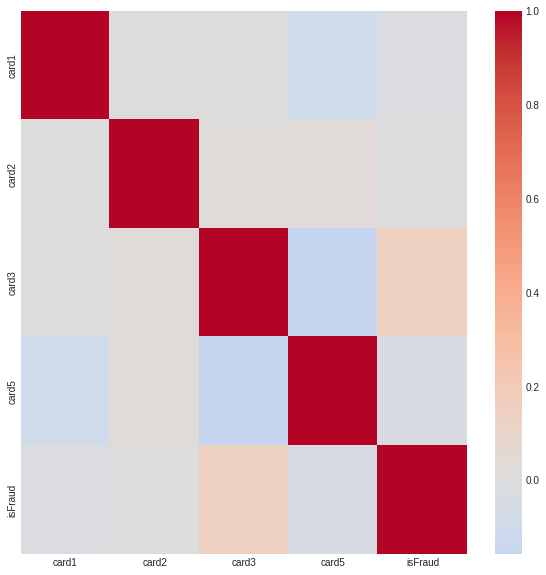

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_train[cards].corr(), annot=False, center=0.0,
            cmap='coolwarm')  # cmap="YlGnBu",
plt.show()


1.我們可以看到信用卡中存在更多欺詐交易的機會。它約佔所有交易的 6.5%。<br>
2.同樣在 card4 discover卡中欺詐案件最高，約為 7.6%<br>
3.card3 與其他卡片功能的相關性較低。<br>

## 6.P_email domain and R_email domain

In [ ]:
print('train_data:P_emaildomain缺失值',df_train['P_emaildomain'].isnull().sum())
print('train_data:R_emaildomain缺失值',df_train['R_emaildomain'].isnull().sum())
print('test_data:P_emaildomain缺失值',df_test['P_emaildomain'].isnull().sum())
print('test_data:R_emaildomain缺失值',df_test['R_emaildomain'].isnull().sum())

train_data:P_emaildomain缺失值 94456
train_data:R_emaildomain缺失值 453249
test_data:P_emaildomain缺失值 69192
test_data:R_emaildomain缺失值 370821


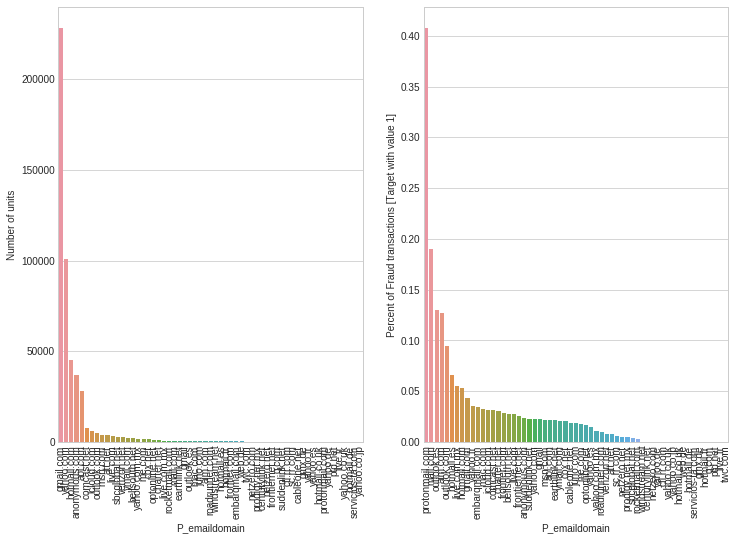

In [ ]:
hor_plot('P_emaildomain',label_rotation=True)

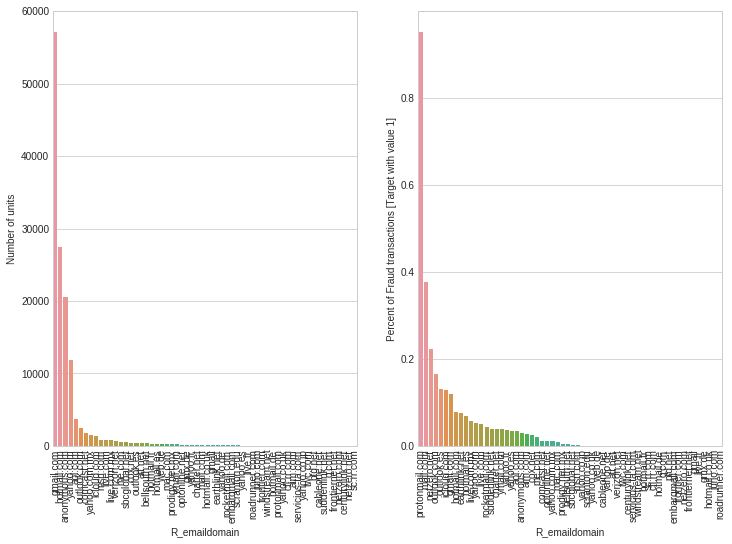

In [ ]:
hor_plot('R_emaildomain',label_rotation=True)

1.在買方電子郵件域中，大多數郵件來自 gmail.com<br>
2.其中更多的欺詐交易來自域 protonmail.com，超過 90%，這是一個嚴重的問題。

## 7.DeviceType

In [ ]:
print('train_data遺失值',df_train['DeviceType'].isnull().sum())
print('test_data缺失值',df_test['DeviceType'].isnull().sum())

train_data遺失值 449730
test_data缺失值 369760


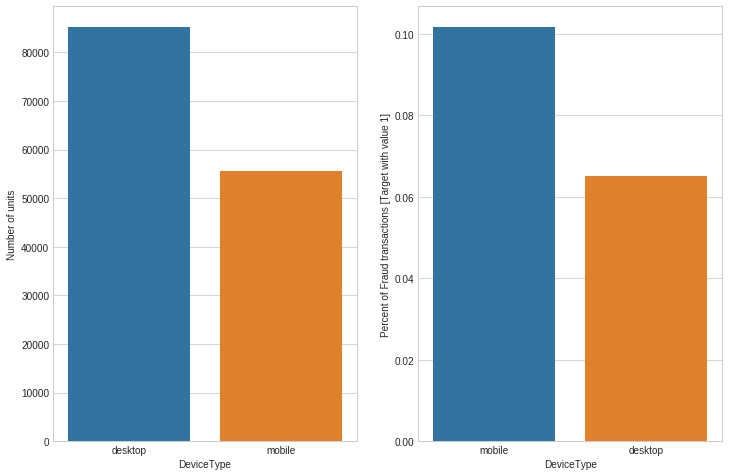

In [ ]:
hor_plot('DeviceType',df_train)

我們可以看到欺詐交易主要是在mobile上進行的，大約有 10% 左右，而桌面交易中只有 6.2% 是欺詐交易。

## 8.Device Info

In [ ]:
print('train_data遺失值',df_train['DeviceInfo'].isnull().sum())
print('test_data缺失值',df_test['DeviceInfo'].isnull().sum())

train_data遺失值 471874
test_data缺失值 391634


In [ ]:
print(df_train['DeviceInfo'].nunique())

1786


In [ ]:
tmp = df_train[['DeviceInfo', 'isFraud']].groupby(
    by=['DeviceInfo']).mean().sort_values(by='isFraud', ascending=False)
print(tmp[tmp['isFraud'] > 0.9].shape)
tmp[tmp['isFraud'] > 0.9]


(49, 1)


,isFraud
DeviceInfo,
ZTE-Z835,1.000000
Dream,1.000000
SM-T285M,1.000000
A5002,1.000000
A466BG,1.000000
SM-T530,1.000000
Blade L3 Build/KOT49H,1.000000
RNE-L23 Build/HUAWEIRNE-L23,1.000000
SAMSUNG-SM-N900A,1.000000


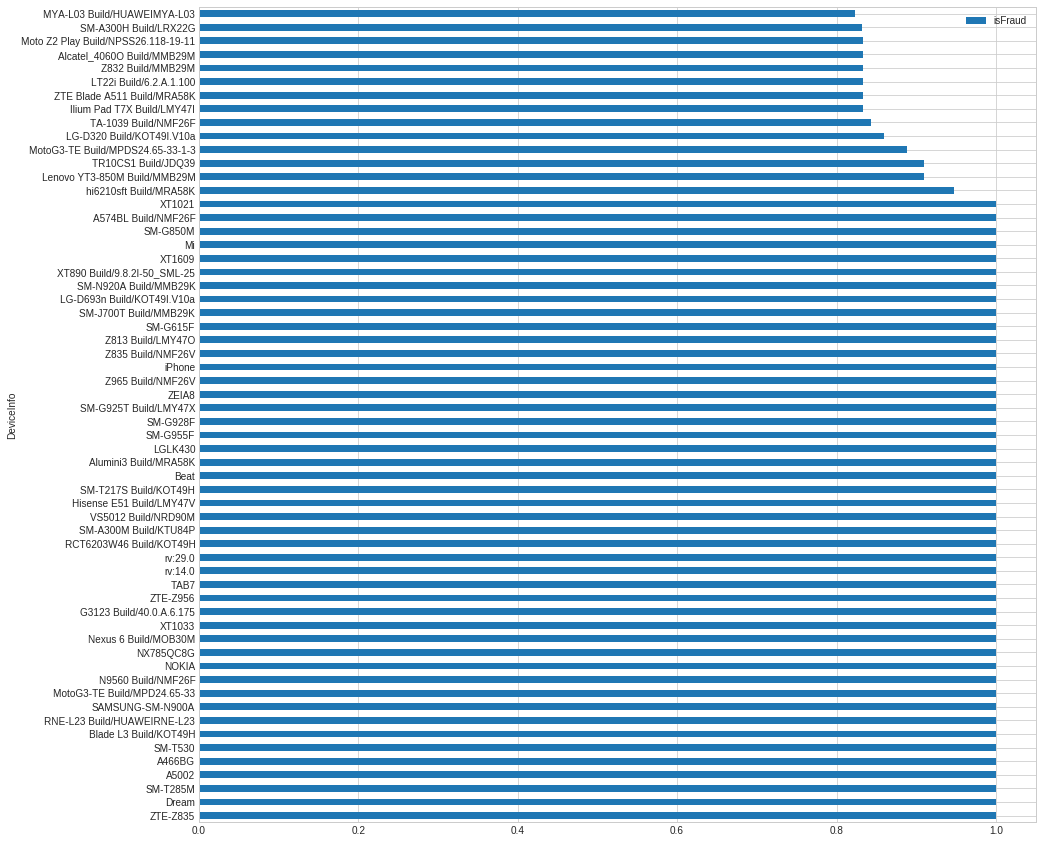

In [ ]:
tmp.head(60).plot(kind='barh', figsize=(15, 15))
plt.show()


We can see that about 49 device information we have chances of being fraud transaction > 90%

# Basic Model (Logistic Regression)

In [ ]:
import pandas as pd
df_train = pd.read_csv('./ieee-fraud-detection/train_combined.csv')
df_test = pd.read_csv('./ieee-fraud-detection/test_combined.csv')
print(df_train.shape)
print(df_test.shape)


(590540, 434)
(506691, 433)


In [ ]:
# column details
cat_cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

######################################################################################

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols =  [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 
    'id_09', 'id_10', 'id_11'
]


In [ ]:
## Train and test split¶
y_train_ = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590540, 433)
(506691, 433)


41

In [ ]:
# Label encoding all cat features
for col in X_train.columns:
    if col in cat_cols:
        # label encode all cat columns
        dff = pd.concat([X_train[col],X_test[col]])
        dff,_ = pd.factorize(dff,sort=True)
        if dff.max()>32000: 
            print(col,'needs int32 datatype')
            
        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')

In [ ]:
# Scaling numeric features
cols = X_train.columns
for col in cols:
    if col not in cat_cols and col not in id_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

In [ ]:
# # train test split
# from sklearn.model_selection import train_test_split
# x_train,x_cv_,y_train,y_cv = train_test_split(X_train,y_train, stratify = y_train,test_size=0.3, random_state=40)

idx_train = X_train.index[:int(X_train.shape[0]*0.75)]  
idx_validation = X_train.index[int(X_train.shape[0]*0.75):]

x_train,y_train = X_train.iloc[idx_train],y_train_.iloc[idx_train]
x_cv_,y_cv = X_train.iloc[idx_validation],y_train_.iloc[idx_validation]


print(x_train.shape)
print(x_cv_.shape)
print(y_train.shape)
print(y_cv.shape)

(442905, 433)
(147635, 433)
(442905,)
(147635,)


### Logistic Regression

In [ ]:
model = LogisticRegression()
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv,model.predict_proba(x_cv_)[:,1]
)

#Area under ROC curve   
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


Area under train roc 0.5457290804371077
Area under test roc 0.5322381884875885


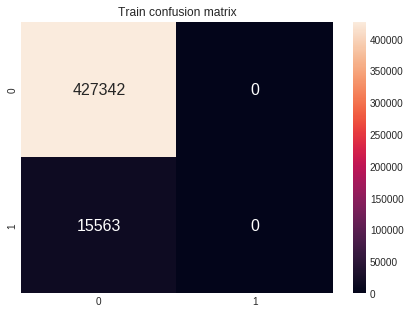

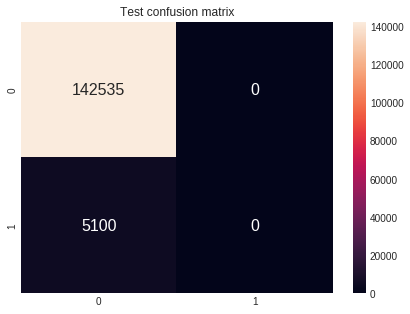

0.9648615391562525
0.9654553459545501
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Train confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
### Accuracy 不準確例子
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

## RandomForest

Area under train roc 1.0
Area under test roc 0.881066765851112


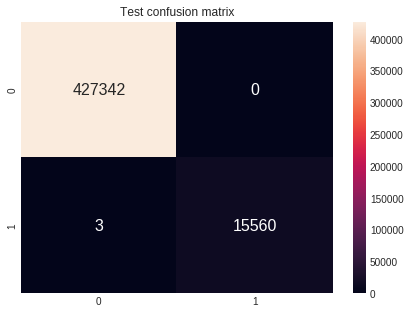

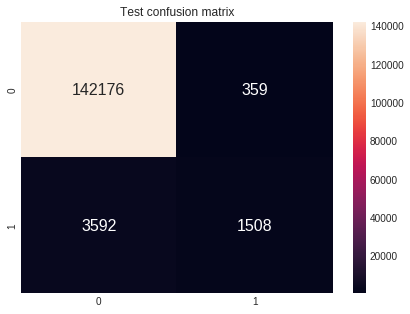

0.9999932265384225
0.9732380533071426
1.0
0.8077129084092126
0.9998072351089121
0.29568627450980395
0.9999036082639848
0.43289794746662835


In [ ]:
## RandomForest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs= -1)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

## XGBoost

In [ ]:
model = xgb.XGBClassifier(
    missing=-1, learning_rate=0.02,n_jobs=-1,verbose=50,
    eval_metric='auc', colsample_bytree=0.4, max_depth=12, n_estimators=2000, subsample=0.8)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


Area under train roc 0.9998837858776336
Area under test roc 0.9166253991967572


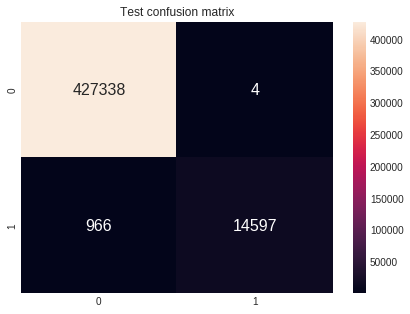

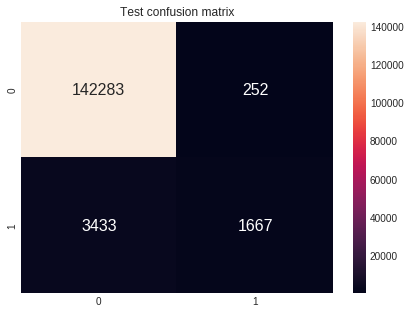

0.997809914089929
0.975039794086768
0.9997260461612218
0.8686816050026055
0.9379297050697166
0.3268627450980392
0.9678424612120409
0.47499643823906534


In [ ]:
train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

## 調整參數

In [ ]:
model = LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',n_jobs=-1)
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv,model.predict_proba(x_cv_)[:,1]
)

#Area under ROC curve   
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.8661460369172289
Area under test roc 0.8202715803548768


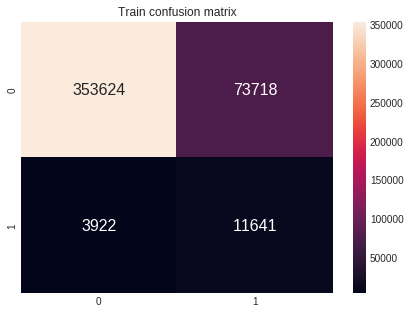

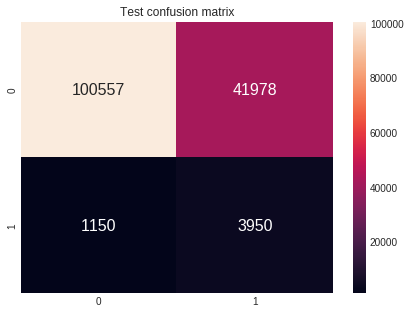

0.8247028143732855
0.7078741490838893
0.13637694912077228
0.08600418045636649
0.7479920323845017
0.7745098039215687
0.23069301044370902
0.1548169632358705


In [ ]:
train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Train confusion matrix')
plt.show()

cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
### Accuracy 不準確例子
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

# 特徵工程

### 刪除缺失值（>90 % 欄位）


In [ ]:
X_train.shape

(590540, 433)

In [ ]:
X_drop = X_train.copy() 

In [ ]:
X_drop =X_drop.drop(columns = ['id_21','id_22','id_23','id_24','id_25','id_26','id_27','id_07','id_08','id_18','dist2','D7'])

In [ ]:
X_drop.shape

(590540, 421)

In [ ]:
X_test =X_test.drop(columns = ['id_21','id_22','id_23','id_24','id_25','id_26','id_27','id_07','id_08','id_18','dist2','D7'])

In [ ]:
X_test.shape

(506691, 421)

In [ ]:
# # train test split
# from sklearn.model_selection import train_test_split
# x_train,x_cv_,y_train,y_cv = train_test_split(X_train,y_train, stratify = y_train,test_size=0.3, random_state=40)

idx_train = X_drop.index[:int(X_drop.shape[0]*0.75)]  
idx_validation = X_drop.index[int(X_drop.shape[0]*0.25):]

x_train,y_train = X_drop.iloc[idx_train],y_train_.iloc[idx_train]
x_cv_,y_cv = X_drop.iloc[idx_validation],y_train_.iloc[idx_validation]


print(x_train.shape)
print(x_cv_.shape)
print(y_train.shape)
print(y_cv.shape)

(442905, 421)
(442905, 421)
(442905,)
(442905,)


Area under train roc 0.8657879730188383
Area under test roc 0.8510711028585239


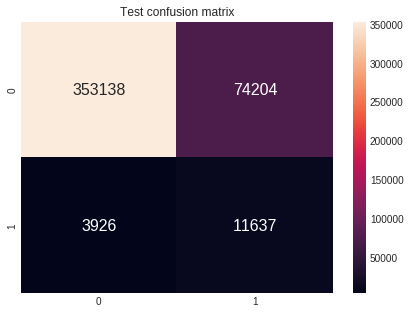

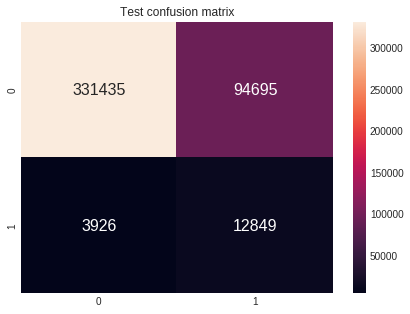

0.8235964823156208
0.7773314819205022
0.13556459034726995
0.11947667931265342
0.747735012529718
0.7659612518628912
0.22951757327127134
0.20671015693498176


In [ ]:
## logisticRegression
model = LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',n_jobs=-1)
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv,model.predict_proba(x_cv_)[:,1]
)

#Area under ROC curve   
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))



Area under train roc 1.0
Area under test roc 0.9833131628667294


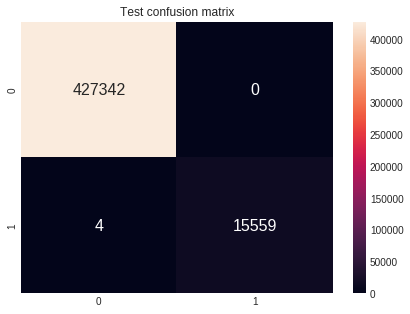

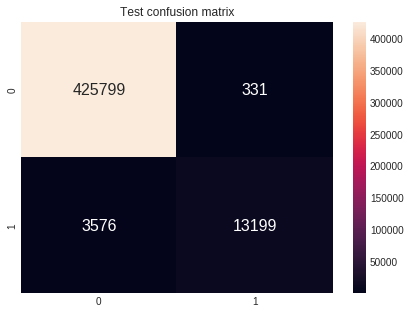

0.9999909687178966
0.9911786952055182
1.0
0.9755358462675536
0.9997429801452162
0.7868256333830105
0.9998714735556841
0.8710773799703021


In [ ]:
## RandomForest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs= -1)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

Area under train roc 0.9998843137901194
Area under test roc 0.9745348126204149


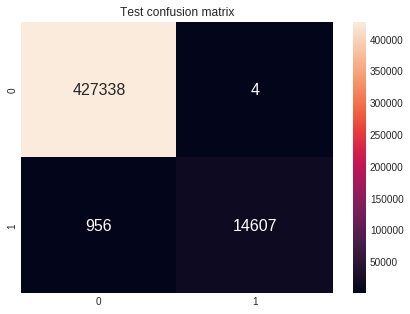

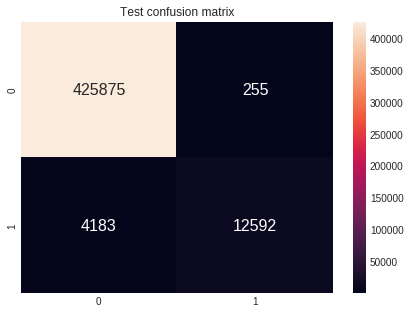

0.9978324922951874
0.9899797925062936
0.9997262336595716
0.9801510080174359
0.938572254706676
0.7506408345752608
0.9681845297275802
0.850178921072176


In [ ]:
##XGBoost
model = xgb.XGBClassifier(
    missing=-1, learning_rate=0.02,n_jobs=-1,
    eval_metric='auc', colsample_bytree=0.4, max_depth=12, n_estimators=2000, subsample=0.8)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

Area under train roc 0.9708141797418803
Area under test roc 0.8239853642054825


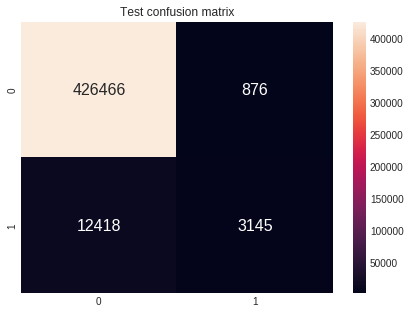

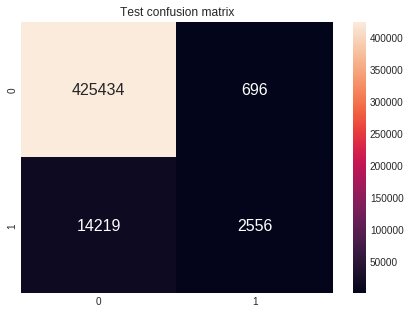

0.969984533929398
0.966324606857001
0.7821437453369808
0.7859778597785978
0.20208186082374863
0.15236959761549926
0.3211805555555555
0.25525540520297596


In [ ]:
##KNN
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_jobs=-1)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

### TransactionAmt取log


In [ ]:
X_log = X_drop.copy()
X_log['transactionAmt_log'] = np.log(X_train[['TransactionAmt']])


In [ ]:
X_log = X_log.drop(columns='TransactionAmt')

In [ ]:
X_log.shape

(590540, 421)

In [ ]:
X_test['transactionAmt_log'] = np.log(X_test[['TransactionAmt']])
X_test = X_test.drop(columns='TransactionAmt')
X_test.shape

(506691, 433)

In [ ]:
# # train test split
# from sklearn.model_selection import train_test_split
# x_train,x_cv_,y_train,y_cv = train_test_split(X_train,y_train, stratify = y_train,test_size=0.3, random_state=40)

idx_train = X_log.index[:int(X_log.shape[0]*0.75)]  
idx_validation = X_log.index[int(X_log.shape[0]*0.25):]

x_train,y_train = X_log.iloc[idx_train],y_train_.iloc[idx_train]
x_cv_,y_cv = X_log.iloc[idx_validation],y_train_.iloc[idx_validation]


print(x_train.shape)
print(x_cv_.shape)
print(y_train.shape)
print(y_cv.shape)

(442905, 421)
(442905, 421)
(442905,)
(442905,)


Area under train roc 0.8701127038246013
Area under test roc 0.8551759590866721


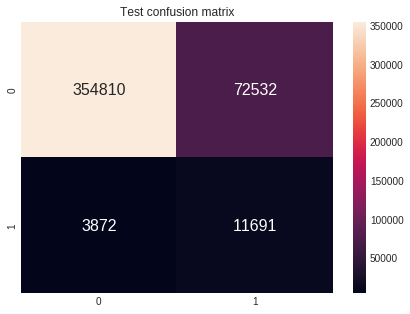

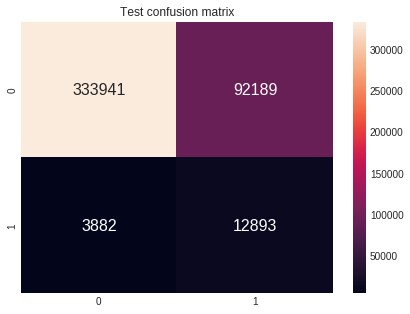

0.8274934805432316
0.7830889242614104
0.13881006375930566
0.12269465750556709
0.751204780569299
0.7685842026825633
0.2343214478985028
0.2116086888730233


In [ ]:
## logisticRegression
model = LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',n_jobs=-1)
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv,model.predict_proba(x_cv_)[:,1]
)

#Area under ROC curve   
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

Area under train roc 0.9999999995489213
Area under test roc 0.9836477921786145


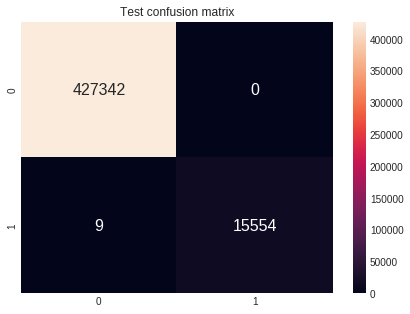

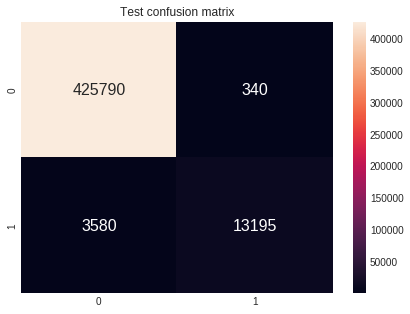

0.9999796796152673
0.9911493435386821
1.0
0.9748799408939786
0.9994217053267365
0.7865871833084948
0.9997107690330045
0.8706697459584295


In [ ]:
## RandomForest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs= -1)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

Area under train roc 0.9998750163054816
Area under test roc 0.9736673735333246


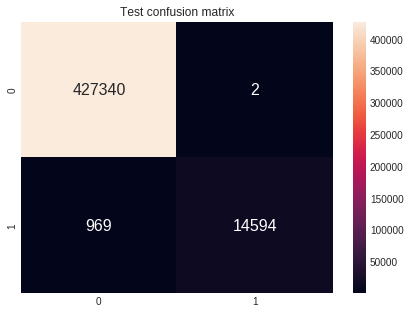

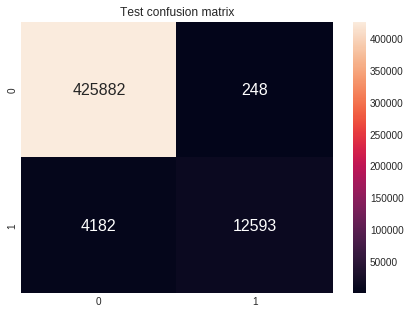

0.9978076562694032
0.9899978550705004
0.9998629761578515
0.9806868623938946
0.9377369401786289
0.7507004470938897
0.9678039722802481
0.8504186925985954


In [ ]:
##XGBoost
model = xgb.XGBClassifier(
    missing=-1, learning_rate=0.02,n_jobs=-1,
    eval_metric='auc', colsample_bytree=0.4, max_depth=12, n_estimators=2000, subsample=0.8)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

Area under train roc 0.9708141797418803
Area under test roc 0.8239853642054825


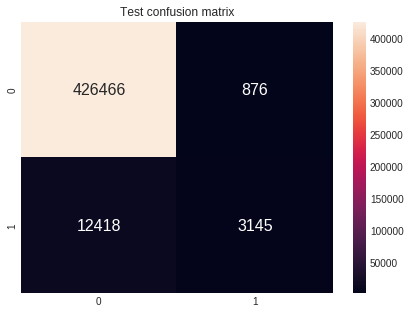

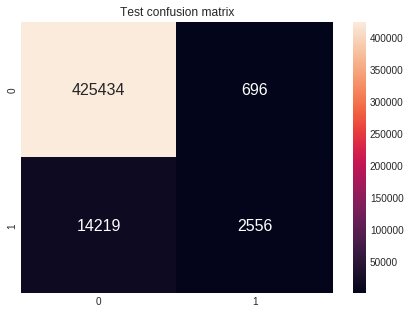

0.969984533929398
0.966324606857001
0.7821437453369808
0.7859778597785978
0.20208186082374863
0.15236959761549926
0.3211805555555555
0.25525540520297596


In [ ]:
##KNN
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_jobs=-1)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

### PCA (V1-V399)

In [ ]:
X_pca = X_log.copy()

In [ ]:
X_pca.shape

(590540, 421)

In [ ]:
x_vv = X_pca.iloc[:,55:394]
x_vv.shape

(590540, 339)

In [ ]:
# PCA V1-V399
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(x_vv)
variances=pca.explained_variance_
thresh=0.7
useful_features=variances>thresh
# print(useful_features) # 標記為True的表示重要特徵，要保留，False則刪除
useful_features_num=np.sum(useful_features) # 計算True的個數
# 進行PCA降維之後的新數據集為：
pca.n_components=useful_features_num # 即設置PCA的新特徵數量為n_components
new_dataset_X=pca.fit_transform(x_vv)
print('before PCA, dataset shape: ', x_vv.shape)
print('after PCA, dataset shape: ', new_dataset_X.shape)


before PCA, dataset shape:  (590540, 339)
after PCA, dataset shape:  (590540, 4)


In [ ]:
X_pca['p1'] = new_dataset_X[:,0]
X_pca['p2'] = new_dataset_X[:,1]
X_pca['p3'] = new_dataset_X[:,2]
X_pca['p4'] = new_dataset_X[:,3]

In [ ]:
X_pca = X_pca.drop(columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 
    'V337', 'V338', 'V339'])

In [ ]:
# # train test split
# from sklearn.model_selection import train_test_split
# x_train,x_cv_,y_train,y_cv = train_test_split(X_train,y_train, stratify = y_train,test_size=0.3, random_state=40)

idx_train = X_pca.index[:int(X_pca.shape[0]*0.75)]  
idx_validation = X_pca.index[int(X_pca.shape[0]*0.75):]

x_train,y_train = X_pca.iloc[idx_train],y_train_.iloc[idx_train]
x_cv_,y_cv = X_pca.iloc[idx_validation],y_train_.iloc[idx_validation]


print(x_train.shape)
print(x_cv_.shape)
print(y_train.shape)
print(y_cv.shape)

(442905, 86)
(147635, 86)
(442905,)
(147635,)


Area under train roc 0.8251870851406458
Area under test roc 0.8127909264803898


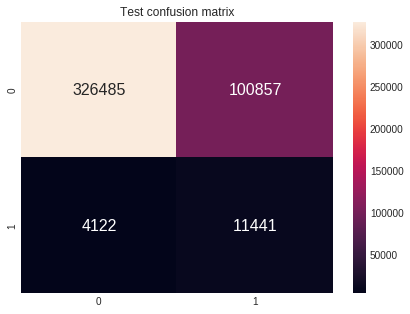

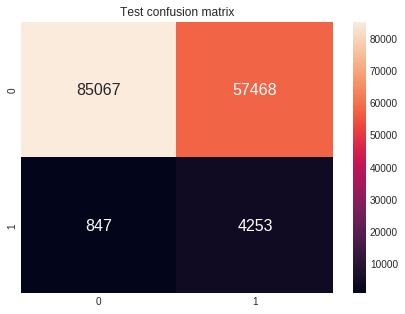

0.7629762590171707
0.6050055881058015
0.10188071025307664
0.06890685504123394
0.7351410396453126
0.8339215686274509
0.17895996433627143
0.12729531135421499


In [ ]:
## logisticRegression
model = LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',n_jobs=-1)
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv,model.predict_proba(x_cv_)[:,1]
)

#Area under ROC curve   
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

Area under train roc 1.0000000000000002
Area under test roc 0.8870335851462695


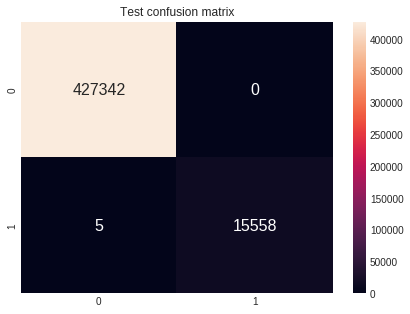

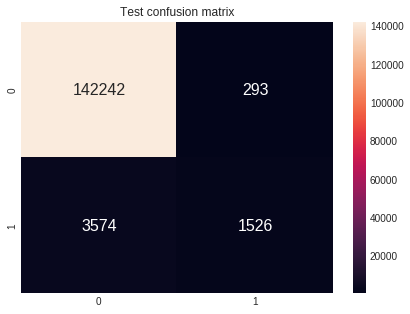

0.9999887108973707
0.9738070240796559
1.0
0.8389224848818032
0.9996787251815202
0.2992156862745098
0.999839336782237
0.44110420581008813


In [ ]:
## RandomForest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs= -1)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

Area under train roc 0.9999529869197182
Area under test roc 0.9198196947842876


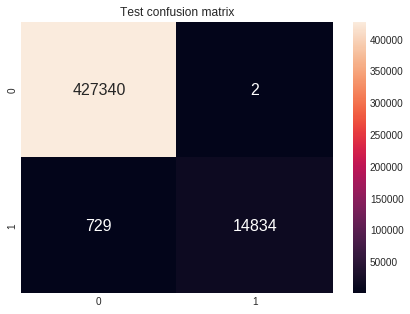

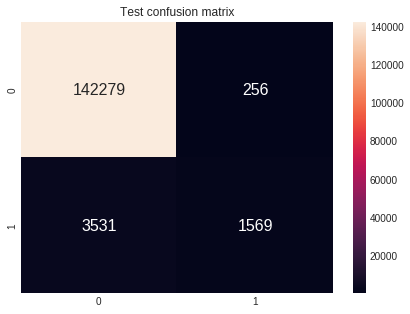

0.9983495331956063
0.974348901005859
0.9998651927743327
0.8597260273972602
0.9531581314656558
0.3076470588235294
0.9759531563538274
0.45314079422382664


In [ ]:
##XGBoost
model = xgb.XGBClassifier(
    missing=-1, learning_rate=0.02,n_jobs=-1,
    eval_metric='auc', colsample_bytree=0.4, max_depth=12, n_estimators=2000, subsample=0.8)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))

Area under train roc 0.9708141797418803
Area under test roc 0.5


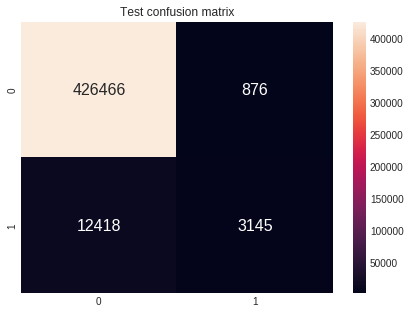

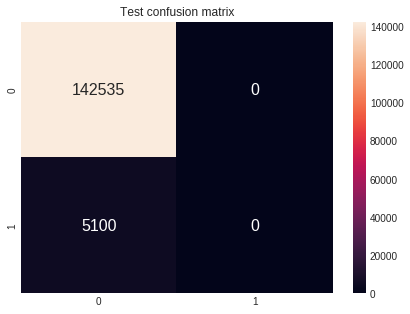

0.969984533929398
0.9654553459545501
0.7821437453369808
0.0
0.20208186082374863
0.0
0.3211805555555555
0.0


In [ ]:
 ##KNN
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_jobs=-1)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:,1]
)
test_fpr, test_tpr, thresholds = roc_curve(
    y_cv, model.predict_proba(x_cv_)[:, 1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr,train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize = (7,5))
sns.heatmap(train_cf, annot = True, annot_kws = {"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title('Test confusion matrix')
plt.show()
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_cv,y_test_pred))
print(precision_score(y_train, y_train_pred))
print(precision_score(y_cv,y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_cv,y_test_pred))
print(f1_score(y_train, y_train_pred))
print(f1_score(y_cv,y_test_pred))